# Preliminary operations

We import the libraries and the drive environment.

In [ ]:
!pip install folium
!pip install geopandas
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Utility
from google.colab import drive
import pandas as pd
import numpy as np
from shutil import copyfile, copy
import datetime
import urllib.request
import os
import json
import matplotlib.pyplot as plt

# Geo
import folium
import geopandas as gpd

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
import keras_tuner
from kerastuner.tuners import RandomSearch, GridSearch

seq_len = 5
n_feats = 5

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pd.set_option('display.max_columns', None)

# Loading data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/DSLSC/motoscooter_movimento_new.csv')

In [ ]:
df.columns

Index(['provider_id', 'lat', 'lng', 'created_at', 'distance', 'placename',
       'placelat', 'placelon', 'lat&lng', 'prevObservation', 'nextObservation',
       'nextCreated_at', 'nextDistance', 'nextTimeDiff', 'prevCreated_at',
       'prevDistance', 'prevTimeDiff', 'samePlace', 'type'],
      dtype='object')

In [ ]:
df['created_at'] =  pd.to_datetime(df['created_at'], format = '%Y%m%d %H:%M:%S')
df['nextCreated_at'] =  pd.to_datetime(df['nextCreated_at'], format = '%Y%m%d %H:%M:%S')
df['prevCreated_at'] =  pd.to_datetime(df['prevCreated_at'], format = '%Y%m%d %H:%M:%S')
# Remove waiting long e-scooters
df = df[df['type'] != 'waiting long']

Now we order the dataframe by provider and we order each provider by time. This way, we will have sequences of consecutive pick-up/drop-off synchronized for each provider_id.


In [ ]:
groups = df.groupby('provider_id')
ordered_df = []
for name, group in groups:
  ordered_df.append((pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True))

In [ ]:
combined_df = pd.concat(ordered_df)

In [ ]:
combined_df

,provider_id,lat,lng,created_at,distance,placename,placelat,placelon,lat&lng,prevObservation,nextObservation,nextCreated_at,nextDistance,nextTimeDiff,prevCreated_at,prevDistance,prevTimeDiff,samePlace,type
0,2.0,45.4599,9.20633,2019-12-06 01:25:20,143.437209,356.0,45.46075,9.20495,"(45.4599, 9.20633)",NaN,"(45.4622, 9.19374)",2019-12-06 01:40:22,1017.327131,15.033333,NaT,0.000000,0.000000,0.0,first seen / pick-up
1,2.0,45.4622,9.19374,2019-12-06 01:40:22,214.500848,354.0,45.46075,9.19555,"(45.4622, 9.19374)","(45.4599, 9.20633)","(45.4621, 9.19375)",2019-12-06 01:55:23,11.141565,15.016667,2019-12-06 01:25:20,1017.327131,15.033333,0.0,drop-off
2,2.0,45.4621,9.19375,2019-12-06 18:40:20,205.745441,354.0,45.46075,9.19555,"(45.4621, 9.19375)","(45.4621, 9.19375)","(45.4411, 9.18597)",2019-12-06 19:40:24,2411.994485,60.066667,2019-12-06 18:25:21,0.000000,14.983333,0.0,pick-up outlier
3,2.0,45.4411,9.18597,2019-12-06 19:40:24,95.513288,204.0,45.44195,9.18615,"(45.4411, 9.18597)","(45.4621, 9.19375)","(45.4411, 9.18597)",2019-12-06 19:55:25,0.000000,15.016667,2019-12-06 18:40:20,2411.994485,60.066667,0.0,drop-off outlier
4,2.0,45.4411,9.18597,2019-12-06 20:10:24,95.513288,204.0,45.44195,9.18615,"(45.4411, 9.18597)","(45.4411, 9.18597)","(45.4721, 9.18426)",2019-12-06 20:55:22,3447.956963,44.966667,2019-12-06 19:55:25,0.000000,14.983333,0.0,pick-up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,1754.0,45.4567,9.14835,2019-12-07 06:55:08,73.915845,307.0,45.45605,9.14855,"(45.4567, 9.14835)","(45.4566, 9.14827)","(45.4567, 9.14835)",2019-12-07 07:10:09,0.000000,15.016667,2019-12-07 06:25:08,12.754525,30.000000,0.0,drop-off
42,1754.0,45.4567,9.14835,2019-12-07 18:55:14,73.915845,307.0,45.45605,9.14855,"(45.4567, 9.14835)","(45.4567, 9.14835)","(45.4565, 9.14819)",2019-12-07 19:10:08,25.509056,14.900000,2019-12-07 18:40:08,0.000000,15.100000,0.0,pick-up
43,1754.0,45.4565,9.14819,2019-12-07 19:10:08,57.395490,307.0,45.45605,9.14855,"(45.4565, 9.14819)","(45.4567, 9.14835)","(45.4565, 9.14819)",2019-12-07 19:25:09,0.000000,15.016667,2019-12-07 18:55:14,25.509056,14.900000,0.0,drop-off
44,1754.0,45.4565,9.14819,2019-12-08 14:25:08,57.395490,307.0,45.45605,9.14855,"(45.4565, 9.14819)","(45.4565, 9.14819)","(45.4567, 9.14828)",2019-12-08 14:40:08,23.316224,15.000000,2019-12-08 14:10:10,0.000000,14.966667,0.0,pick-up


The sorting done above allows us to correctly associate, for each sample, the pick-up points with the drop-off points.

In [ ]:
pickup = ['first seen / pick-up', 'pick-up', 'pick-up outlier']
dropoff = ['last seen / drop-off', 'drop-off', 'drop-off outlier']
# Create 2 different dataframes: one for pick-up and one for drop-off
df_p = combined_df[combined_df['type'].isin(pickup)]
df_d = combined_df[combined_df['type'].isin(dropoff)]

The 2 dataframes are ordered by provider_id and each provider_id is ordered by time. They are syncrhonized, so that for example the first row is both the pick-up point and the drop-off point of the same scooter, in respectively df_p and df_d.

In [ ]:
df_p = df_p[['provider_id', 'created_at', 'placename', 'placelon', 'placelat']].reset_index(drop = True)
df_d = df_d[['created_at', 'placename', 'placelon', 'placelat']].reset_index(drop = True)
# The placename and the coordinates of the drop-off observation are our target
df_p['target'] = df_d['placename']
df_p['target_lon'] = df_d['placelon']
df_p['target_lat'] = df_d['placelat']
df = df_p.copy()

We also may create a variable indicating if it's saturday or sunday.

In [ ]:
df['is_weekend'] = df['created_at'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

In [ ]:
df

,provider_id,created_at,placename,placelon,placelat,target,target_lon,target_lat,is_weekend
0,2.0,2019-12-06 01:25:20,356.0,9.20495,45.46075,354.0,9.19555,45.46075,0
1,2.0,2019-12-06 18:40:20,354.0,9.19555,45.46075,204.0,9.18615,45.44195,0
2,2.0,2019-12-06 20:10:24,204.0,9.18615,45.44195,426.0,9.18615,45.47015,0
3,2.0,2019-12-07 00:25:20,426.0,9.18615,45.47015,503.0,9.20025,45.47955,1
4,2.0,2019-12-07 08:40:16,503.0,9.20025,45.47955,503.0,9.20025,45.47955,1
...,...,...,...,...,...,...,...,...,...
40779,1754.0,2019-12-07 01:55:08,307.0,9.14855,45.45605,307.0,9.14855,45.45605,1
40780,1754.0,2019-12-07 02:40:09,307.0,9.14855,45.45605,307.0,9.14855,45.45605,1
40781,1754.0,2019-12-07 06:25:08,307.0,9.14855,45.45605,307.0,9.14855,45.45605,1
40782,1754.0,2019-12-07 18:55:14,307.0,9.14855,45.45605,307.0,9.14855,45.45605,1


# Zone prediction \#2 (5 e-scooters)

The goal of this task is to build a prediction model in order to know in advance the drop-off zone of a sequence of scooters (with probability attached). Here we perform a classification task on all the Milan NIL, i.e. with a higher level of granularity.

## Pre-processing

In [ ]:
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = gpd.points_from_xy(df.placelon, df.placelat))

In [ ]:
milan_nil = gpd.read_file("/content/gdrive/MyDrive/DSLSC/NIL_E0.zip")

In [ ]:
# Ensuring the crs is the same
if gdf.crs != milan_nil.crs:
  milan_nil = milan_nil.to_crs(gdf.crs)

In [ ]:
# Spatial join between the zones and scooters GeoDataFrames
zones_with_scooters_gdf = gpd.sjoin(milan_nil, gdf, predicate = 'contains')
# Group the GeoDataFrame by zone ID and count the number of scooters in each zone
scooter_counts_by_zone = zones_with_scooters_gdf.groupby('NIL').size()
# Get the IDs of the zones with scooters
zones_with_scooters_ids = scooter_counts_by_zone.index
# Filter the zones GeoDataFrame in order to remove the zones without scooters
zones_gdf = milan_nil[milan_nil['NIL'].isin(zones_with_scooters_ids)]
zones_gdf = zones_gdf.reset_index(drop = True)

In [ ]:
city = zones_gdf.copy()
city['newNIL'] = zones_gdf['NIL']
for i in range(len(city)):
  if(city['NIL'][i] == 'BOVISA'):
    city['NIL'][i] = 'FARINI'
    city['newNIL'][i] = 'FARINI'
  elif(city['NIL'][i] == 'CITTA\' STUDI'):
    city['NIL'][i] = 'BUENOS AIRES - VENEZIA'
    city['newNIL'][i] = 'BUENOS AIRES - VENEZIA'
  elif(city['NIL'][i] == 'GIARDINI PORTA VENEZIA'):
    city['NIL'][i] = 'GUASTALLA'
    city['newNIL'][i] = 'GUASTALLA'
  elif(city['NIL'][i] == 'QT 8'):
    city['NIL'][i] = 'VILLAPIZZONE'
    city['newNIL'][i] = 'VILLAPIZZONE'
city = city.to_crs(epsg = 4326).dissolve(by = 'newNIL')

<ipython-input-52-471b6c4ccb41>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['NIL'][i] = 'VILLAPIZZONE'
<ipython-input-52-471b6c4ccb41>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['newNIL'][i] = 'VILLAPIZZONE'
<ipython-input-52-471b6c4ccb41>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city['NIL'][i] = 'BUENOS AIRES - VENEZIA'
<ipython-input-52-471b6c4ccb41>:9: SettingWithCopyWarning: 
A value is trying to be s

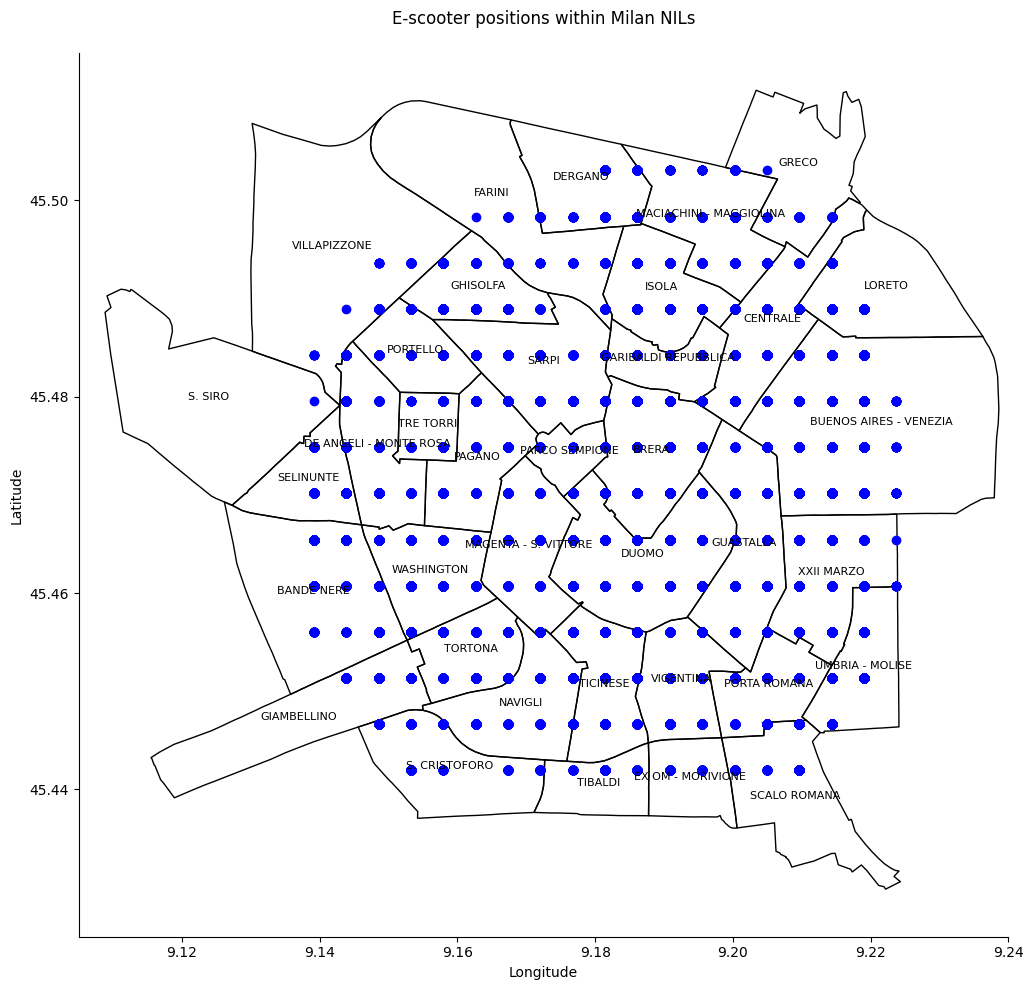

In [ ]:
# Plot the quarters polygons
ax = city.plot(edgecolor = 'k', facecolor = 'none', figsize = (15, 10))
gdf.plot(ax = ax, color = "blue")
ax.set_title('E-scooter positions within Milan NILs\n')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Loop over the quarters polygons and add the name as text
for idx, row in city.iterrows():
  ax.annotate(text = row['NIL'], xy = row['geometry'].centroid.coords[0], ha = 'center', fontsize = 8)

# Set the axis limits
ax.set_xlim(9.105, 9.24)
ax.set_ylim(45.425, 45.515)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('Milan NILs.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
zones_with_scooters_gdf.reset_index(drop = True, inplace = True)

In [ ]:
zones_with_scooters_gdf['NIL'].unique()

array(['QT 8', 'S. SIRO', 'GHISOLFA', 'GIAMBELLINO', 'S. CRISTOFORO',
       'TIBALDI', 'EX OM - MORIVIONE', 'FARINI', 'UMBRIA - MOLISE',
       "CITTA' STUDI", 'SELINUNTE', 'GUASTALLA', 'BRERA', 'DUOMO',
       'SCALO ROMANA', 'MAGENTA - S. VITTORE', 'VILLAPIZZONE', 'BOVISA',
       'DERGANO', 'PORTELLO', 'TRE TORRI', 'PARCO SEMPIONE',
       'GIARDINI PORTA VENEZIA', 'TORTONA', 'NAVIGLI', 'XXII MARZO',
       'BUENOS AIRES - VENEZIA', 'CENTRALE', 'GRECO', 'LORETO',
       'MACIACHINI - MAGGIOLINA', 'ISOLA', 'SARPI',
       'DE ANGELI - MONTE ROSA', 'WASHINGTON', 'BANDE NERE',
       'PORTA ROMANA', 'VIGENTINA', 'TICINESE', 'PAGANO',
       'GARIBALDI REPUBBLICA'], dtype=object)

In [ ]:
keyList = list(zones_with_scooters_gdf['NIL'].unique())
place_dict = {key: [] for key in keyList}
for i in range(0, len(zones_with_scooters_gdf)):
  if not isinstance(zones_with_scooters_gdf['placename'][i], str):
    place_dict[zones_with_scooters_gdf['NIL'][i]].append(zones_with_scooters_gdf['placename'][i])

In [ ]:
for key, value in place_dict.items():
  value = list(set(value))
  place_dict[key] = value

In [ ]:
for i in range(0, len(df)):
  for key, value in place_dict.items():
    if df['target'][i] in value:
      df['target'][i] = key
      break 

<ipython-input-58-b555a8282ce4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][i] = key


In [ ]:
df = df[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend', 'target']].reset_index(drop = True)

In [ ]:
df

,provider_id,created_at,placelon,placelat,is_weekend,target
0,2.0,2019-12-06 01:25:20,9.20495,45.46075,0,DUOMO
1,2.0,2019-12-06 18:40:20,9.19555,45.46075,0,TIBALDI
2,2.0,2019-12-06 20:10:24,9.18615,45.44195,0,BRERA
3,2.0,2019-12-07 00:25:20,9.18615,45.47015,1,CENTRALE
4,2.0,2019-12-07 08:40:16,9.20025,45.47955,1,CENTRALE
...,...,...,...,...,...,...
40779,1754.0,2019-12-07 01:55:08,9.14855,45.45605,1,BANDE NERE
40780,1754.0,2019-12-07 02:40:09,9.14855,45.45605,1,BANDE NERE
40781,1754.0,2019-12-07 06:25:08,9.14855,45.45605,1,BANDE NERE
40782,1754.0,2019-12-07 18:55:14,9.14855,45.45605,1,BANDE NERE


Let's check the zones with few e-scooters and aggregate them to the nearest zone.


In [ ]:
groups = df.groupby('target')
for name, group in groups:
  if(len(group) < 100):
    print(name)

BOVISA
CITTA' STUDI
GIARDINI PORTA VENEZIA
QT 8


In [ ]:
for i in range(len(df)):
  if(df['target'][i] == 'BOVISA'):
    df['target'][i] = 'FARINI'
  elif(df['target'][i] == 'CITTA\' STUDI'):
    df['target'][i] = 'BUENOS AIRES - VENEZIA'
  elif(df['target'][i] == 'GIARDINI PORTA VENEZIA'):
    df['target'][i] = 'GUASTALLA'
  elif(df['target'][i] == 'QT 8'):
    df['target'][i] = 'VILLAPIZZONE'

<ipython-input-62-0e99215fbd33>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][i] = 'GUASTALLA'
<ipython-input-62-0e99215fbd33>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][i] = 'VILLAPIZZONE'
<ipython-input-62-0e99215fbd33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][i] = 'FARINI'
<ipython-input-62-0e99215fbd33>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [ ]:
# We discard samples in a way that there are only multiple of seq_len
ordered_df = []
for name, group in groups:
  df_ = (pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True)
  if(len(group)%seq_len == 0):
    ordered_df.append(df_)
  else:
    df_ = df_[:-((len(df_))%seq_len)]
    ordered_df.append(df_)

In [ ]:
combined_df = pd.concat(ordered_df)

In [ ]:
combined_df

,provider_id,created_at,placelon,placelat,is_weekend,target
0,1342.0,2019-12-02 00:10:11,9.13915,45.46545,0,BANDE NERE
1,1285.0,2019-12-02 00:25:11,9.13915,45.46545,0,BANDE NERE
2,1342.0,2019-12-02 00:40:09,9.13915,45.46545,0,BANDE NERE
3,1373.0,2019-12-02 00:40:09,9.14385,45.46545,0,BANDE NERE
4,1098.0,2019-12-02 00:40:09,9.14385,45.46545,0,BANDE NERE
...,...,...,...,...,...,...
1495,1246.0,2019-12-08 23:25:10,9.21435,45.45605,1,XXII MARZO
1496,1395.0,2019-12-08 23:25:10,9.21905,45.45605,1,XXII MARZO
1497,1066.0,2019-12-08 23:25:11,9.22375,45.46075,1,XXII MARZO
1498,1070.0,2019-12-08 23:25:11,9.21435,45.46545,1,XXII MARZO


In [ ]:
df = combined_df.reset_index(drop = True)

## Preparation

In [ ]:
encoder_id = LabelEncoder()
df['provider_id'] = encoder_id.fit_transform(df['provider_id'])

In [ ]:
encoder_target = LabelEncoder()
df['target'] = encoder_id.fit_transform(df['target'])

In [ ]:
# Converting datetime in unixtime (int)
dates = pd.to_datetime(df['created_at'])
df['created_at'] = dates.astype(int) // 10**9
min_time = min(df['created_at'])
df['created_at'] = df['created_at'] - min_time
#df['created_at'] = df['created_at'] % 86400

In [ ]:
# Test-set = monday
test = df[df['created_at'] < 1575331200 - min_time]
train = df.drop(test.index)
test.reset_index(drop = True, inplace = True)
train.reset_index(drop = True, inplace = True)

In [ ]:
max_test = max(test['created_at'])
train['created_at'] = train['created_at'] - max_test
max_train = max(train['created_at'])
test['created_at'] = test['created_at'] + max_train

<ipython-input-71-1feb4cdfc222>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['created_at'] = test['created_at'] + max_train


In [ ]:
train_test_ordered = pd.concat([train, test], ignore_index = True)

In [ ]:
scaler_0 = MinMaxScaler()
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()
scaler_3 = MinMaxScaler()

df['provider_id'] = scaler_0.fit_transform(np.array(df['provider_id']).reshape(-1, 1))
train_test_ordered['created_at'] = scaler_1.fit_transform(np.array(train_test_ordered['created_at']).reshape(-1, 1))

train['provider_id'] = scaler_0.transform(np.array(train['provider_id']).reshape(-1, 1))
train['created_at'] = scaler_1.transform(np.array(train['created_at']).reshape(-1, 1))
train['placelon'] = scaler_2.fit_transform(np.array(train['placelon']).reshape(-1, 1))
train['placelat'] = scaler_3.fit_transform(np.array(train['placelat']).reshape(-1, 1))

test['provider_id'] = scaler_0.transform(np.array(test['provider_id']).reshape(-1, 1))
test['created_at'] = scaler_1.transform(np.array(test['created_at']).reshape(-1, 1))
test['placelon'] = scaler_2.transform(np.array(test['placelon']).reshape(-1, 1))
test['placelat'] = scaler_3.transform(np.array(test['placelat']).reshape(-1, 1))

<ipython-input-73-c99ba37fc144>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['provider_id'] = scaler_0.transform(np.array(test['provider_id']).reshape(-1, 1))
<ipython-input-73-c99ba37fc144>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['created_at'] = scaler_1.transform(np.array(test['created_at']).reshape(-1, 1))
<ipython-input-73-c99ba37fc144>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Now we create the validation set, selecting the last 10% of each target. Moreover, we save the array with training + validation for further retraining.

In [ ]:
X = train.copy(deep = True)

In [ ]:
val = pd.DataFrame(columns = train.columns)

for i in range(0, 36):
  to_pick = int((len(train[train['target'] == i]))*0.1)
  rows = train[train['target'] == i].tail(to_pick)
  train = train.drop(rows.index)
  val = pd.concat([val, rows], ignore_index = True)

train.reset_index(drop = True, inplace = True)

In [ ]:
# Now we have to fix the lengths of train, val and test, in the same way as before
groups = train.groupby('target')
ordered_df_train = []
for name, group in groups:
  df_ = (pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True)
  if(len(group)%seq_len != 0):
    df_ = df_[:-((len(df_))%seq_len)]
  ordered_df_train.append(df_)

groups = val.groupby('target')
ordered_df_val = []
for name, group in groups:
  df_ = (pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True)
  if(len(group)%seq_len != 0):
    df_ = df_[:-((len(df_))%seq_len)]
  ordered_df_val.append(df_)
    
groups = test.groupby('target')
ordered_df_test = []
for name, group in groups:
  df_ = (pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True)
  if(len(group)%seq_len != 0):
    df_ = df_[:-((len(df_))%seq_len)]
  ordered_df_test.append(df_)

# Training + validation
groups = X.groupby('target')
ordered_df_X = []
for name, group in groups:
  df_ = (pd.DataFrame(group)).sort_values(by = 'created_at').reset_index(drop = True)
  if(len(group)%seq_len != 0):
    df_ = df_[:-((len(df_))%seq_len)]
  ordered_df_X.append(df_)

In [ ]:
train = pd.concat(ordered_df_train).reset_index(drop = True)
val = pd.concat(ordered_df_val).reset_index(drop = True)
test = pd.concat(ordered_df_test).reset_index(drop = True)
X = pd.concat(ordered_df_X).reset_index(drop = True)

In [ ]:
train

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.851976,0.000000,0.000000,0.384615,0,0
1,0.703112,0.000000,0.000000,0.384615,0,0
2,0.684609,0.000000,0.111111,0.307692,0,0
3,0.516400,0.000000,0.000000,0.384615,0,0
4,0.703112,0.001495,0.000000,0.384615,0,0
...,...,...,...,...,...,...
31470,0.529016,0.772737,0.833333,0.153846,1,35
31471,0.993272,0.772742,0.833333,0.384615,1,35
31472,0.677040,0.774237,0.833333,0.384615,1,35
31473,0.699748,0.775735,0.888889,0.230769,1,35


In [ ]:
val

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.791421,0.759279,0.000000,0.307692,1,0
1,0.512195,0.759279,0.111111,0.307692,1,0
2,0.826745,0.759279,0.000000,0.384615,1,0
3,0.767031,0.760773,0.111111,0.307692,1,0
4,0.671993,0.765256,0.111111,0.230769,1,0
...,...,...,...,...,...,...
3415,0.706476,0.853448,0.888889,0.230769,1,35
3416,0.535744,0.853452,0.833333,0.307692,1,35
3417,0.706476,0.856433,0.888889,0.230769,1,35
3418,0.797309,0.856433,0.944444,0.230769,1,35


In [ ]:
test

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.765349,0.857965,0.000000,0.384615,0,0
1,0.730866,0.859460,0.000000,0.384615,0,0
2,0.765349,0.860951,0.000000,0.384615,0,0
3,0.785534,0.860951,0.055556,0.384615,0,0
4,0.619849,0.860951,0.055556,0.384615,0,0
...,...,...,...,...,...,...
5585,0.717410,0.996976,0.777778,0.538462,0,35
5586,0.522288,0.998467,0.888889,0.384615,0,35
5587,0.780488,0.999965,0.888889,0.384615,0,35
5588,0.737595,0.999965,0.833333,0.384615,0,35


In [ ]:
X

,provider_id,created_at,placelon,placelat,is_weekend,target
0,0.851976,0.000000,0.000000,0.384615,0,0
1,0.703112,0.000000,0.000000,0.384615,0,0
2,0.684609,0.000000,0.111111,0.307692,0,0
3,0.516400,0.000000,0.000000,0.384615,0,0
4,0.703112,0.001495,0.000000,0.384615,0,0
...,...,...,...,...,...,...
34960,0.597981,0.853447,1.000000,0.307692,1,35
34961,0.601346,0.853447,0.888889,0.384615,1,35
34962,0.706476,0.853448,0.888889,0.230769,1,35
34963,0.535744,0.853452,0.833333,0.307692,1,35


In [ ]:
X_train = np.array((train[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)
y_train = np.array((train['target'])).reshape(-1, seq_len)

X_val = np.array((val[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)
y_val = np.array((val['target'])).reshape(-1, seq_len)

X_test = np.array((test[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)
y_test = np.array((test['target'])).reshape(-1, seq_len)

y = np.array((X['target'])).reshape(-1, seq_len)
X = np.array((X[['provider_id', 'created_at', 'placelon', 'placelat', 'is_weekend']])).reshape(-1, seq_len, n_feats)

In [ ]:
y_train = to_categorical(y_train)[:, 0, :]
y_val = to_categorical(y_val)[:, 0, :]
y_test = to_categorical(y_test)[:, 0, :]
y = to_categorical(y)[:, 0, :]

In [ ]:
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

(6295, 5, 5)
(6295, 36)
(684, 5, 5)
(684, 36)
(1118, 5, 5)
(1118, 36)
(6993, 5, 5)
(6993, 36)


## Model selection

We use a RNN LSTM for this task. In this section we start from a basic network and select the best model iteratively.

### Model 0

In [ ]:
model0 = Sequential()
model0.add(LSTM(16, input_shape = (seq_len, n_feats), return_sequences = True))
model0.add(LSTM(32, return_sequences = False))
model0.add(Dense(32))
model0.add(Dense(36, activation = 'softmax'))
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 16)             1408      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 36)                1188      
                                                                 
Total params: 9,924
Trainable params: 9,924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = Adam(learning_rate = 0.0001)
model0.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history0 = model0.fit(X_train, y_train, epochs = 100, batch_size = 16, validation_data = (X_val, y_val))

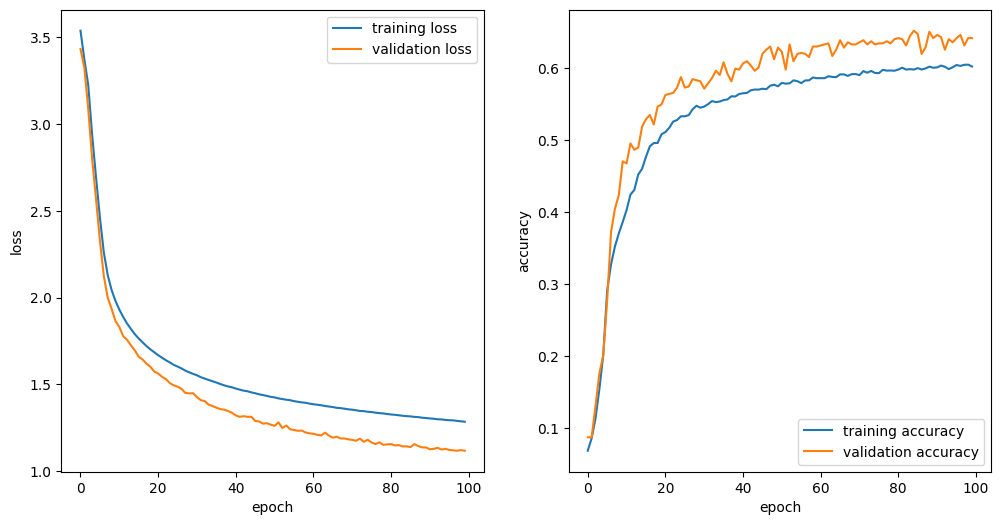

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model0 = Sequential()
model0.add(LSTM(16, input_shape = (seq_len, n_feats), return_sequences = True))
model0.add(LSTM(32, return_sequences = False))
model0.add(Dense(32))
model0.add(Dense(36, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.0001)
model0.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history0 = model0.fit(X, y, epochs = 100, batch_size = 16)

Epoch 1/100
438/438 [==============================] - 8s 8ms/step - loss: 3.5337 - accuracy: 0.0714
Epoch 2/100
438/438 [==============================] - 5s 11ms/step - loss: 3.3328 - accuracy: 0.0881
Epoch 3/100
438/438 [==============================] - 4s 9ms/step - loss: 3.1204 - accuracy: 0.1257
Epoch 4/100
438/438 [==============================] - 4s 9ms/step - loss: 2.6914 - accuracy: 0.2427
Epoch 5/100
438/438 [==============================] - 4s 9ms/step - loss: 2.3799 - accuracy: 0.2927
Epoch 6/100
438/438 [==============================] - 5s 12ms/step - loss: 2.2154 - accuracy: 0.3120
Epoch 7/100
438/438 [==============================] - 4s 9ms/step - loss: 2.1083 - accuracy: 0.3589
Epoch 8/100
438/438 [==============================] - 4s 8ms/step - loss: 2.0277 - accuracy: 0.3800
Epoch 9/100
438/438 [==============================] - 4s 10ms/step - loss: 1.9622 - accuracy: 0.3994
Epoch 10/100
438/438 [==============================] - 4s 10ms/step - loss: 1.9089 - ac

In [ ]:
model0.save('/content/gdrive/MyDrive/DSLSC/Models_2/Model0_5.h5')

### Keras tuner \#1

In [ ]:
#!rm -rf /content/best_hyperparams_1

Now we use the keras tuner in order to find the best units combination.

In [ ]:
# 16 different combinations
def build_model_1(hp):
  model = Sequential()
  model.add(LSTM(units = hp.Int('units_lstm_1', min_value = 16, max_value = 32, step = 16),
                  input_shape = (seq_len, n_feats),
                  return_sequences = True))
  model.add(LSTM(units = hp.Int('units_lstm_2', min_value = 32, max_value = 64, step = 32),
                  return_sequences = False))
  model.add(Dense(units = hp.Int('units_dense', min_value = 32, max_value = 64, step = 32)))
  model.add(Dense(36, activation = 'softmax'))
  
  optimizer = Adam(learning_rate = hp.Choice('learning_rate', values = [0.001, 0.0001]))
  model.compile(optimizer =  optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_1 = GridSearch(
  build_model_1,
  objective = 'val_loss',
  executions_per_trial = 1,
  directory = '/content',
  project_name = 'best_hyperparams_1'
)

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
# Grid search
tuner_1.search(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

In [ ]:
# Retrieve best hyperparameters and final model
best_hp = tuner_1.get_best_hyperparameters()[0]
best_model = tuner_1.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4864      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 36)                1188      
                                                                 
Total params: 15,428
Trainable params: 15,428
Non-trainable params: 0
_________________________________________________________________


Let's try this model.

### Model 1

In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model1.add(LSTM(32, return_sequences = False))
model1.add(Dense(32))
model1.add(Dense(36, activation = 'softmax'))
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             4864      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 36)                1188      
                                                                 
Total params: 15,428
Trainable params: 15,428
Non-trainable params: 0
_________________________________________________________________


In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history1 = model1.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

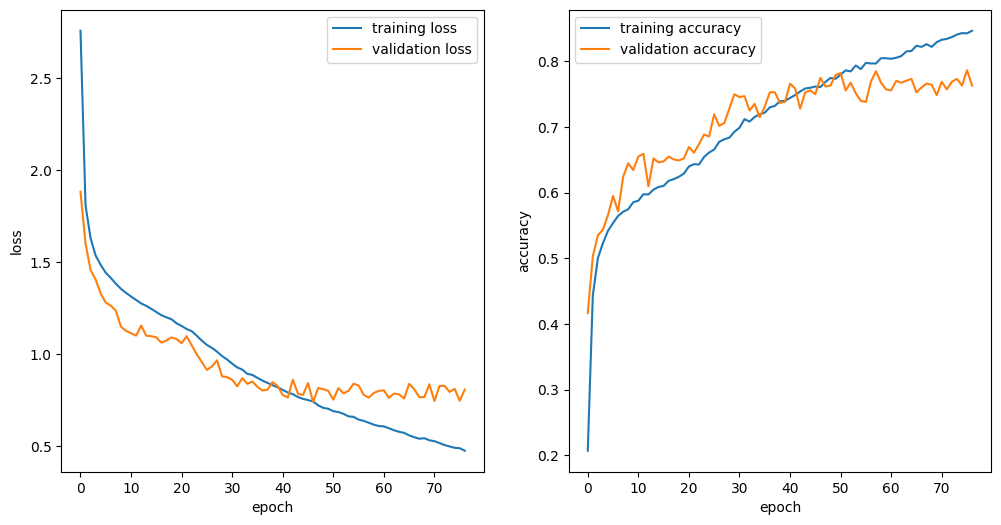

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model1 = Sequential()
model1.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model1.add(LSTM(32, return_sequences = False))
model1.add(Dense(32))
model1.add(Dense(36, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model1.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history1 = model1.fit(X, y, epochs = 75, batch_size = 16)

Epoch 1/75
438/438 [==============================] - 12s 13ms/step - loss: 2.5329 - accuracy: 0.2747
Epoch 2/75
438/438 [==============================] - 4s 10ms/step - loss: 1.7310 - accuracy: 0.4730
Epoch 3/75
438/438 [==============================] - 4s 10ms/step - loss: 1.5686 - accuracy: 0.5230
Epoch 4/75
438/438 [==============================] - 6s 13ms/step - loss: 1.4820 - accuracy: 0.5451
Epoch 5/75
438/438 [==============================] - 4s 10ms/step - loss: 1.4287 - accuracy: 0.5530
Epoch 6/75
438/438 [==============================] - 4s 10ms/step - loss: 1.3902 - accuracy: 0.5651
Epoch 7/75
438/438 [==============================] - 6s 13ms/step - loss: 1.3553 - accuracy: 0.5822
Epoch 8/75
438/438 [==============================] - 5s 10ms/step - loss: 1.3394 - accuracy: 0.5784
Epoch 9/75
438/438 [==============================] - 4s 10ms/step - loss: 1.3011 - accuracy: 0.5873
Epoch 10/75
438/438 [==============================] - 5s 12ms/step - loss: 1.2838 - accur

In [ ]:
model1.save('/content/gdrive/MyDrive/DSLSC/Models_2/Model1_5.h5')

### Keras tuner \#2

In [ ]:
#!rm -rf /content/best_hyperparams_2

Now we use the keras tuner in order to find the best dropout combination.

In [ ]:
# 12 different combinations
def build_model_2(hp):
  model = Sequential()
  model.add(LSTM(units = 32, input_shape = (seq_len, n_feats), return_sequences = True))
  model.add(Dropout(hp.Float('dropout_lstm_1', min_value = 0.0, max_value = 0.2, step = 0.2)))
  model.add(LSTM(units = 32, return_sequences = False))
  model.add(Dropout(hp.Float('dropout_lstm_2', min_value = 0.0, max_value = 0.2, step = 0.2)))
  model.add(Dense(units = 32))
  model.add(Dropout(hp.Float('dropout_dense', min_value = 0.0, max_value = 0.4, step = 0.2)))
  model.add(Dense(36, activation = 'softmax'))
  
  optimizer = Adam(learning_rate = 0.001)
  model.compile(optimizer =  optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_2 = GridSearch(
  build_model_2,
  objective = 'val_loss',
  executions_per_trial = 1,
  directory = '/content',
  project_name = 'best_hyperparams_2'
)

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
# Grid search
tuner_2.search(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

In [ ]:
# Retrieve best hyperparameters and final model
best_hp = tuner_2.get_best_hyperparameters()[0]
best_model = tuner_2.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_3 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 36)               

Let's try this model.

### Model 2

In [ ]:
model2 = Sequential()
model2.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(32, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(32))
model2.add(Dropout(0.2))
model2.add(Dense(36, activation = 'softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_6 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 36)               

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history2 = model2.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

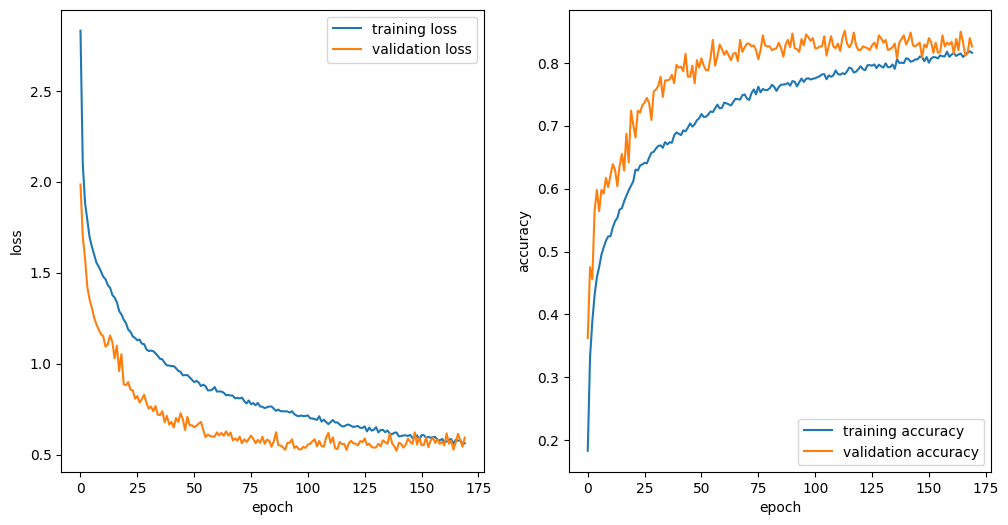

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model2 = Sequential()
model2.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(32, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(32))
model2.add(Dropout(0.2))
model2.add(Dense(36, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model2.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history2 = model2.fit(X, y, epochs = 175, batch_size = 16)

Epoch 1/175
438/438 [==============================] - 11s 14ms/step - loss: 2.9799 - accuracy: 0.1529
Epoch 2/175
438/438 [==============================] - 5s 11ms/step - loss: 2.0698 - accuracy: 0.3318
Epoch 3/175
438/438 [==============================] - 5s 12ms/step - loss: 1.8481 - accuracy: 0.4034
Epoch 4/175
438/438 [==============================] - 6s 13ms/step - loss: 1.7254 - accuracy: 0.4417
Epoch 5/175
438/438 [==============================] - 5s 11ms/step - loss: 1.6588 - accuracy: 0.4673
Epoch 6/175
438/438 [==============================] - 5s 12ms/step - loss: 1.6097 - accuracy: 0.4841
Epoch 7/175
438/438 [==============================] - 8s 18ms/step - loss: 1.5652 - accuracy: 0.5039
Epoch 8/175
438/438 [==============================] - 5s 11ms/step - loss: 1.5239 - accuracy: 0.5187
Epoch 9/175
438/438 [==============================] - 5s 11ms/step - loss: 1.5075 - accuracy: 0.5277
Epoch 10/175
438/438 [==============================] - 6s 14ms/step - loss: 1.49

In [ ]:
model2.save('/content/gdrive/MyDrive/DSLSC/Models_2/Model2_5.h5')

### Keras tuner \#3

In [ ]:
#!rm -rf /content/best_hyperparams_3

Now we use the keras tuner in order to find the best regularizers combination.

In [ ]:
# 64 different combinations
def build_model_3(hp):
  model = Sequential()
  model.add(LSTM(units = 32, input_shape = (seq_len, n_feats), return_sequences = True, 
                 kernel_regularizer = regularizers.l2(hp.Choice('kernel_regularizer_lstm_1', values = [0.0, 0.01])),
                 bias_regularizer = regularizers.l2(hp.Choice('bias_regularizer_lstm_1', values = [0.0, 0.01]))))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 32, return_sequences = False,
                 kernel_regularizer = regularizers.l2(hp.Choice('kernel_regularizer_lstm_2', values = [0.0, 0.01])),
                 bias_regularizer = regularizers.l2(hp.Choice('bias_regularizer_lstm_2', values = [0.0, 0.01]))))
  model.add(Dropout(0.2))
  model.add(Dense(units = 32,
                  kernel_regularizer = regularizers.l2(hp.Choice('kernel_regularizer_dense', values = [0.0, 0.01])),
                  bias_regularizer = regularizers.l2(hp.Choice('bias_regularizer_dense', values = [0.0, 0.01]))))
  model.add(Dropout(0.2))
  model.add(Dense(36, activation = 'softmax'))
  
  optimizer = Adam(learning_rate = 0.001)
  model.compile(optimizer =  optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
tuner_3 = GridSearch(
  build_model_3,
  objective = 'val_loss',
  executions_per_trial = 1,
  directory = '/content',
  project_name = 'best_hyperparams_3'
)

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
# Grid search
tuner_3.search(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_val, y_val), callbacks = [stop_early])

In [ ]:
# Retrieve best hyperparameters and final model
best_hp = tuner_3.get_best_hyperparameters()[0]
best_model = tuner_3.hypermodel.build(best_hp)

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_3 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 36)               

It's the same as model 2.

### Model 4

Now we may try increasing the batch_size to 32.

In [ ]:
model4 = Sequential()
model4.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model4.add(Dropout(0.2))
model4.add(LSTM(32, return_sequences = False))
model4.add(Dropout(0.2))
model4.add(Dense(32))
model4.add(Dropout(0.2))
model4.add(Dense(36, activation = 'softmax'))
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             4864      
                                                                 
 dropout_6 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 36)               

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model4.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history4 = model4.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_data = (X_val, y_val), callbacks = [stop_early])

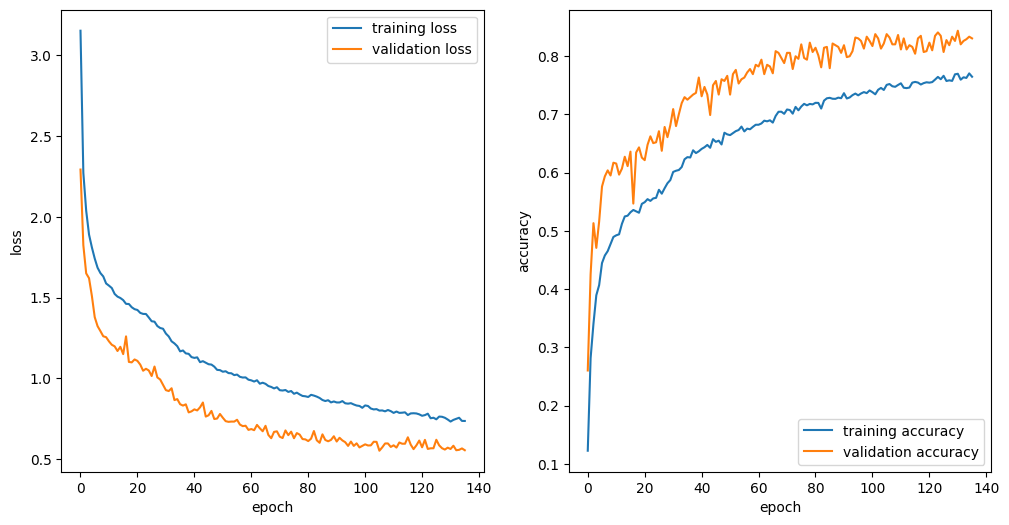

In [ ]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

Now retrain on training + validation and save the model.

In [ ]:
model4 = Sequential()
model4.add(LSTM(32, input_shape = (seq_len, n_feats), return_sequences = True))
model4.add(Dropout(0.2))
model4.add(LSTM(32, return_sequences = False))
model4.add(Dropout(0.2))
model4.add(Dense(32))
model4.add(Dropout(0.2))
model4.add(Dense(36, activation = 'softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
model4.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history4 = model4.fit(X, y, epochs = 175, batch_size = 32)

Epoch 1/175
219/219 [==============================] - 7s 14ms/step - loss: 3.2270 - accuracy: 0.1074
Epoch 2/175
219/219 [==============================] - 3s 13ms/step - loss: 2.3281 - accuracy: 0.2703
Epoch 3/175
219/219 [==============================] - 2s 10ms/step - loss: 2.0137 - accuracy: 0.3534
Epoch 4/175
219/219 [==============================] - 2s 10ms/step - loss: 1.8373 - accuracy: 0.4063
Epoch 5/175
219/219 [==============================] - 2s 10ms/step - loss: 1.7560 - accuracy: 0.4297
Epoch 6/175
219/219 [==============================] - 2s 10ms/step - loss: 1.7011 - accuracy: 0.4553
Epoch 7/175
219/219 [==============================] - 3s 13ms/step - loss: 1.6567 - accuracy: 0.4676
Epoch 8/175
219/219 [==============================] - 3s 13ms/step - loss: 1.6053 - accuracy: 0.4906
Epoch 9/175
219/219 [==============================] - 2s 10ms/step - loss: 1.5893 - accuracy: 0.4889
Epoch 10/175
219/219 [==============================] - 2s 10ms/step - loss: 1.549

In [ ]:
model4.save('/content/gdrive/MyDrive/DSLSC/Models_2/Model4_5.h5')

## Testing

Finally, we load our models in order to evaluate them on the test-set.

### Model 0

In [ ]:
model0 = load_model('/content/gdrive/MyDrive/DSLSC/Models_2/Model0_5.h5')

In [ ]:
y_pred = model0.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

35/35 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        28
           1       0.54      0.68      0.60        56
           2       0.74      0.80      0.77        87
           3       0.40      0.62      0.49        53
           4       0.76      0.52      0.62        25
           5       0.88      0.72      0.79        29
           6       0.57      0.76      0.65       117
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         6
           9       0.75      0.07      0.12        44
          10       0.66      0.94      0.77        47
          11       0.50      0.39      0.44        18
          12       1.00      0.50      0.67         4
          13       0.26      0.15      0.19        34
          14       0.30      0.26      0.28        23
          15       0.68      0.68      0.68        31
          16       0.71     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Prediction')

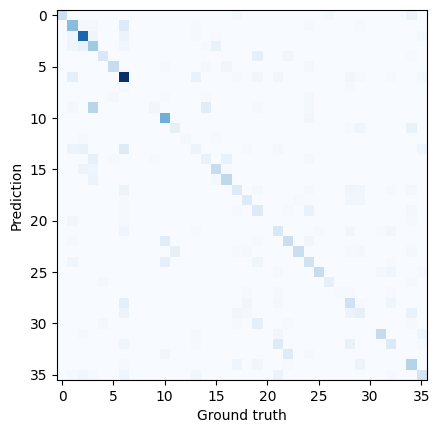

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.7432915921288015
0.8389982110912343


### Model 1

In [ ]:
model1 = load_model('/content/gdrive/MyDrive/DSLSC/Models_2/Model1_5.h5')

In [ ]:
y_pred = model1.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

35/35 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.64      0.64      0.64        56
           2       0.71      0.86      0.78        87
           3       0.71      0.55      0.62        53
           4       0.89      0.64      0.74        25
           5       1.00      0.76      0.86        29
           6       0.75      0.70      0.72       117
           7       0.00      0.00      0.00         3
           8       0.27      0.50      0.35         6
           9       0.84      0.86      0.85        44
          10       0.90      0.91      0.91        47
          11       0.48      0.61      0.54        18
          12       0.67      0.50      0.57         4
          13       0.52      0.32      0.40        34
          14       0.50      0.48      0.49        23
          15       0.69      0.94      0.79        31
          16       0.92     

Text(0, 0.5, 'Prediction')

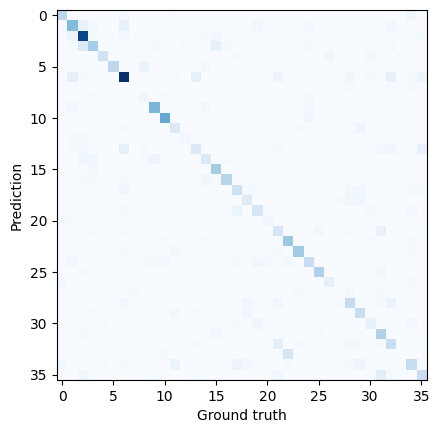

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.813953488372093
0.8765652951699463


### Model 2

In [ ]:
model2 = load_model('/content/gdrive/MyDrive/DSLSC/Models_2/Model2_5.h5')

In [ ]:
y_pred = model2.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

35/35 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        28
           1       0.83      0.70      0.76        56
           2       0.83      0.90      0.86        87
           3       0.83      0.85      0.84        53
           4       0.85      0.88      0.86        25
           5       0.97      1.00      0.98        29
           6       0.80      0.87      0.83       117
           7       0.00      0.00      0.00         3
           8       0.67      0.33      0.44         6
           9       0.87      0.91      0.89        44
          10       0.82      0.96      0.88        47
          11       0.80      0.67      0.73        18
          12       1.00      0.50      0.67         4
          13       0.73      0.65      0.69        34
          14       0.86      0.52      0.65        23
          15       0.96      0.87      0.92        31
          16       0.94     

Text(0, 0.5, 'Prediction')

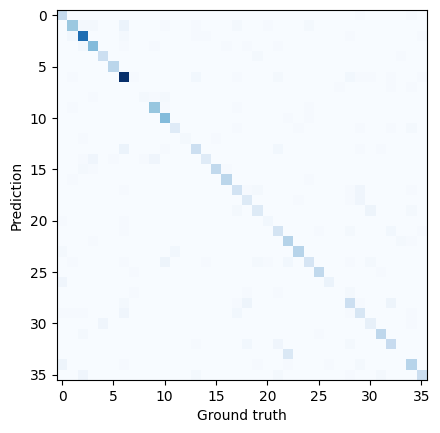

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.8738819320214669
0.9105545617173524


### Model 4

In [ ]:
model4 = load_model('/content/gdrive/MyDrive/DSLSC/Models_2/Model4_5.h5')

In [ ]:
y_pred = model4.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

35/35 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        28
           1       0.76      0.73      0.75        56
           2       0.82      0.86      0.84        87
           3       0.82      0.77      0.80        53
           4       0.76      0.76      0.76        25
           5       1.00      1.00      1.00        29
           6       0.80      0.87      0.84       117
           7       0.00      0.00      0.00         3
           8       0.50      0.67      0.57         6
           9       0.95      0.91      0.93        44
          10       0.79      0.94      0.85        47
          11       0.77      0.56      0.65        18
          12       0.67      0.50      0.57         4
          13       0.73      0.56      0.63        34
          14       0.65      0.65      0.65        23
          15       0.88      0.90      0.89        31
          16       0.90     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Prediction')

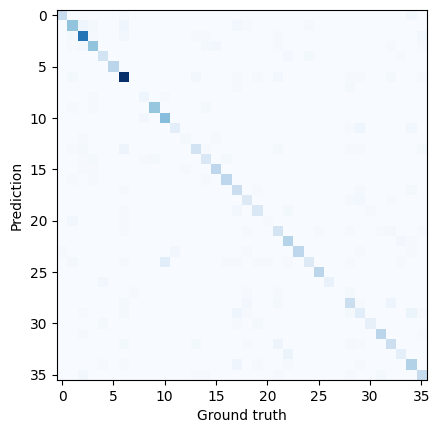

In [ ]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [ ]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.8676207513416816
0.9087656529516994
